In [1]:
using Random, Distributions
using Plots
# plotlyjs()
# using PlotlyJS
using DataFrames
using StatsBase
using DelimitedFiles
using LinearAlgebra
# using Distances
# using Symbolics
# using Latexify

# Problem Set 4 (Jonathan Fischer using Julia)

## 1) Reduced units

In [205]:
function unreduce_units(val, type)
    kb = 1.380649e-23 #Boltzmann constant in J/K
    sigma = 3.3e-10 #length in meters
    e = 300. * kb #energy in J
    m = 40. * 6.023e-23  #mass in grams per molecule

    if type=="temp" #reduced temperature
        T = val
        return T*e/kb #T
    elseif type=="energy" #reduced energy
        U = val 
        return U*e #U
    elseif type=="density" #reduced density 
        sigma_cm = sigma * 100 #convert from meters to cm 
        p = val 
        return p*(m*30/sigma_cm^3)
    elseif type=="time" #time 
        t = val 
        m_kg = m * 1e-3 #mass in SI units
        return t*(sigma*√(m_kg/e))
    end
end

unreduce_units (generic function with 1 method)

### a) Temperature

In [206]:
T = unreduce_units(1, "temp")
println("Temperature: $(T) K")

Temperature: 300.0 K


### b) Density

In [207]:
p = unreduce_units(0.7, "density")
println("Density: $(p) g/cm³")

Density: 1407.8303698138411 g/cm³


### c) Timestep

In [208]:
t = unreduce_units(0.005,"time")
println("Time: $(t) s")

Time: 3.979404647026156e-14 s


## 2) Molecular Dynamics

### function: initialize position matrix

In [2]:
function init_position()
    readdlm("init_crds_boxl_3.5.dat")
end

init_position (generic function with 1 method)

### function: calculate distance with minimum image convention

In [3]:
function calc_dist(x1,x2, L=3.5) #calculate distance between a single pair of points along single component
    dx = x1-x2 
    dx - L*round(dx/L) #distance using minimum image convention 
end

calc_dist (generic function with 2 methods)

### function: calculate LJ potential from a pairwise distance

In [4]:
function calc_LJ(r, sigma = 1, epsilon = 0.25) # calculate Lennard_Jones potential for a pairwise distance
    4*epsilon*((sigma/r)^12 - (sigma/r)^6) 
end

calc_LJ (generic function with 3 methods)

### function: calculate LJ force scalar for pairwise distance

In [41]:
function calc_force(r, sigma = 1, epsilon = 0.25)
    48*epsilon*((sigma^12/r^13)-0.5*(sigma^6/r^7))
end

calc_force (generic function with 3 methods)

### function: UPDATE ACCELERATION MATRIX A (and calculate PE in same loop)

In [72]:
function update_A!(A, R, mass = 1) #update distance matrix D and acceleration matrix A 
    PE = 0 #initialize potential energy
    N = length(R[:,1])
    A = zeros((N,3))
    for i in 1:N-1
        for j in i+1:N
            dr = calc_dist.(R[i,:],R[j,:]) #calculate distance vector between two points
            r_mag = norm(dr) #calculate magnitude of distance vector
            PE += calc_LJ(r_mag) #accumulate LJ potential energy

            f_scalar = calc_force(r_mag) #scalar magnitude of force
            f_vector = f_scalar * dr / r_mag #force vector with each component

            accel_vector = f_vector/mass #get acceleration from Newtons 2nd Law
            A[i,:] += accel_vector
            A[j,:] -= accel_vector
        end
    end
    return PE, A
end

update_A! (generic function with 2 methods)

### function: calculate new position vector of a particle using velocity and acceleration 

In [7]:
function calc_position(r, v, a, dt) #update position vector for single particle
    r + (v*dt) + 0.5(a*dt^2)
end

calc_position (generic function with 1 method)

### function: UPDATE POSITION MATRIX R

In [79]:
function update_R!(R, V, A, dt) #updates position matrix R IN PLACE
    broadcast!(calc_position,R,R,V,A,dt) #vectorized operation passed R by reference 
end

update_R! (generic function with 1 method)

### function: calculate new velocity vector using average of old and new acceleration

In [9]:
function calc_velocity(v,a1,a2,dt) #velocity verlet update of velocity for single component
    v + 0.5*(a1+a2)*dt #average current and new accelerations
end

calc_velocity (generic function with 1 method)

### function: UPDATE VELOCITY MATRIX V 

In [80]:
function update_V!(V,A1,A2,dt) #updates velocity matrix V IN PLACE (passed by reference)
    broadcast!(calc_velocity,V,V,A1,A2,dt)
end

update_V! (generic function with 1 method)

### function: initialize velocities

In [93]:
function init_velocity(T=1., N=30, m=1., kb=1.) #temperature, count, and mass
    V = √(kb*T/m)*randn((N,3)) #return N x 3 matrix of initialized velocities sampled from Maxwell-Boltzmann distribution
    V[end,:] = -sum(V[1:end-1,:],dims=1) #Momentum conservation: last row equals minus sum of all other rows. Mass cancels out because same species 
    return V
end

init_velocity (generic function with 5 methods)

### function: calculate KE 

In [114]:
function calc_KE(V, m)
    KE = 0
    for p in eachrow(V)
        v = √(sum(p.^2)) #get magnitude of velocity vector
        KE += 0.5(m*v^2) #accumulate KE for each particle
    end
    return KE
end

calc_KE (generic function with 1 method)

### function: calculate T

In [110]:
function calc_T(KE,kb,N)
    (KE/(kb*(3N-3)))*(2/3) #calculate T using Equipartition theorem
end

calc_T (generic function with 1 method)

### function: MD simulation

In [152]:
function MD(T, m, dt, iters, R=init_position())
    kb = 1 #Boltzmann constant

    N = length(R[:,1]) #number of particles
    V = init_velocity(T,N,m,kb) #velocity for t
    A = zeros(N,3) #acceleration matrix
    
    PE = Vector{Float64}(undef,iters+1) #initialize array of potential energies 
    PE[1], A = update_A!(A,R,m) #initialize acceleration matrix and return initial PE
    

    KE = Vector{Float64}(undef,iters+1) #initialize array of kinetic energies 
    KE[1] = calc_KE(V,m) #initial KE 

    T_list = Vector{Float64}(undef,iters+1) #initialize array of kinetic energies 
    T_list[1] = calc_T(KE[1],kb,N) #initial temperature


    for i in 1:iters
        update_R!(R,V,A,dt) #new R updated to t+dt
        curr_A = copy(A) #A for current t
        PE[i+1],A = update_A!(A, R, m) #new A updated in-place to t+dt, and returns PE into array 
        update_V!(V,curr_A,A,dt) #new V updated to t+dt
        KE[i+1] = calc_KE(V,m) #add KE
        T_list[i+1] = calc_T(KE[i+1],kb,N) #add T
    end
    return  PE, KE, T_list, A, V, R 
end

MD (generic function with 2 methods)

In [153]:
Random.seed!(1234)
PE, KE, T_list, A, V, R= MD(1.,1,0.005,10000)

([-29.472115017422297, -29.680444475118456, -29.689710340863677, -29.488701273985345, -29.063686639970776, -28.399811083459866, -27.502989090139234, -26.41905999010056, -25.2672299161049, -24.244092937391954  …  -17.48980760515833, -17.630088714836145, -17.825286894286272, -18.06852951438512, -18.35256104721204, -18.671980257841398, -19.024922002222358, -19.40886272282972, -19.822701830330868, -20.26556778170987], [55.53019751018675, 55.737405804715664, 55.74546366127117, 55.54307231256133, 55.116046795689776, 54.45153902594666, 53.55584787494675, 52.47823215588633, 51.338202258199644, 50.329163758951545  …  43.51970006036052, 43.66008575790988, 43.85501383235767, 44.098031087035196, 44.38178721300005, 44.70164860196177, 45.05472915476823, 45.4390216763896, 45.85303923247541, 46.29630175076236], [0.42551875486733143, 0.4271065578905414, 0.4271683039177867, 0.4256174123567918, 0.42234518617386796, 0.4172531726126181, 0.4103896388884808, 0.4021320471715427, 0.3933961858865873, 0.38566409

### a) Energy plot

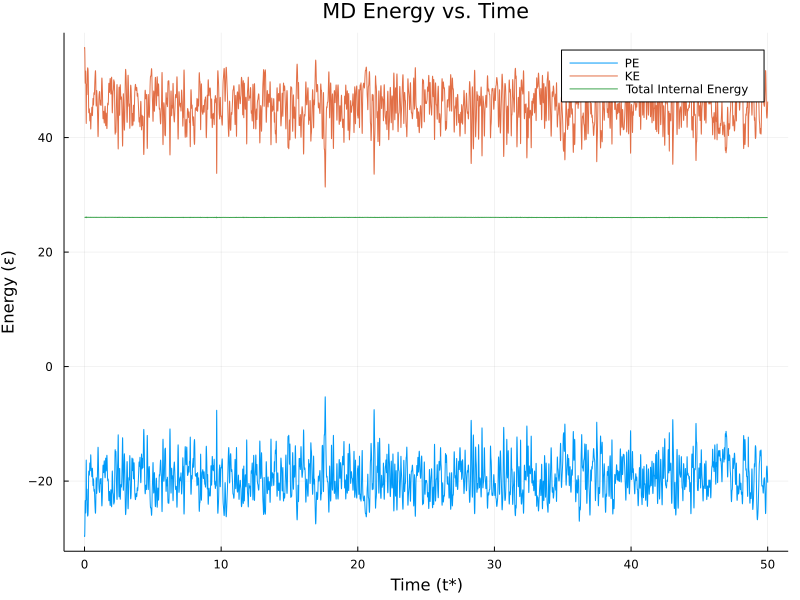

In [209]:
p1 = plot(range(0,length = 10001, step=0.005),PE, label = "PE", size = (800,600))
plot!(range(0,length = 10001, step=0.005),KE, label = "KE")
plot!(range(0,length = 10001, step=0.005),PE+KE, label = "Total Internal Energy")
title!("MD Energy vs. Time")
xlabel!("Time (t*)")
ylabel!("Energy (ε)")
savefig("plot1a.png")
display(p1)

### b) What happens if your time-step is too large?

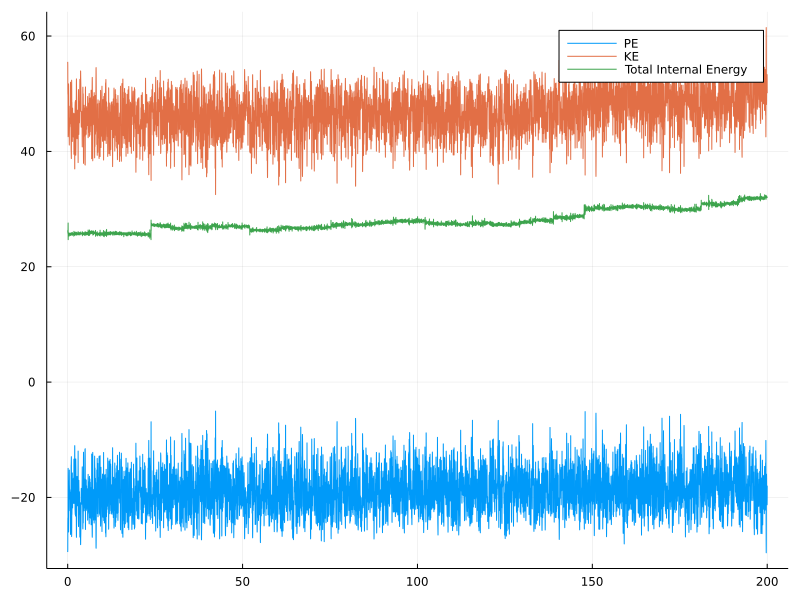

In [228]:
Random.seed!(1234)
stepsize = 0.02
PE, KE, T_list, A, V, R= MD(1.,1,stepsize,10000)
p1 = plot(range(0,length = 10001, step=stepsize),PE, label = "PE", size = (800,600))
plot!(range(0,length = 10001, step=stepsize),KE, label = "KE")
plot!(range(0,length = 10001, step=stepsize),PE+KE, label = "Total Internal Energy")

In [229]:
println("Numerical instability at larger time steps (threshold was 0.02 for me) causes the system's energy to not be conserved and converges to infinity as timestep increases.")

Numerical instability at larger time steps (threshold was 0.02 for me) causes the system's energy to not be conserved and converges to infinity as timestep increases.


### c) Average potential energies

In [175]:
function avg_PE(T_vals)
    # plot(title="Average PE vs. T")
    PEmeans = []
    Tmeans = []
    for T in T_vals
        Random.seed!(1234)
        _,_,_,_,_,R = MD(T,1,0.005,10000)
        PE,_,T, = MD(T,1,0.005,10000,R)
        push!(PEmeans,mean(PE))
        push!(Tmeans,mean(T))
    end
    return PEmeans, Tmeans
end            

avg_PE (generic function with 1 method)

In [176]:
PEmeans,Tmeans = avg_PE([1.,0.5,0.1])

(Any[-8.138468487757622, -20.368586344994046, -32.1856469357073], Any[0.6701184614160958, 0.32926966709038674, 0.07485316705173133])

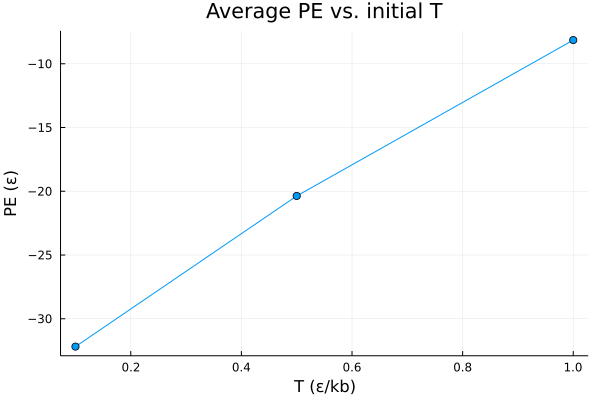

In [247]:
p2 = plot([1.,0.5,0.1],PEmeans, marker = :circle, legend = false)
title!("Average PE vs. initial T")
xlabel!("T (ε/kb)")
ylabel!("PE (ε)")
savefig("plot1c.png")
display(p2)

### d) Average T

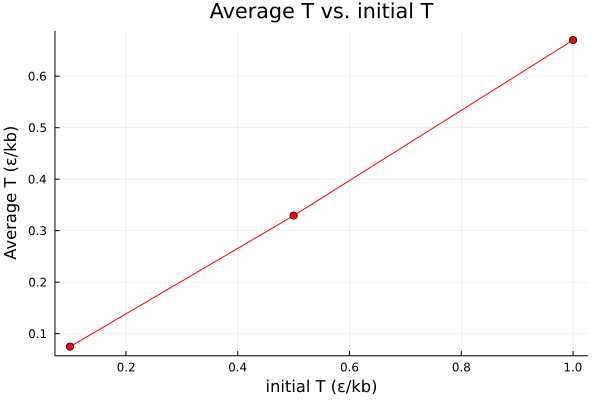

In [211]:
p3 = plot([1.,0.5,0.1],Tmeans, marker = :circle, legend = false, color = :red)
title!("Average T vs. initial T")
xlabel!("initial T (ε/kb)")
ylabel!("Average T (ε/kb)")
savefig("plot1d.png")
display(p3)

## 3) Brownian Dynamics of a particle in a bistable potential

### energy function U(x,y)

In [233]:
function U(x,y)
    lambda = (cot((70/180)*π))^2
    5*((x^2)-1)^2 + (10*lambda*y^2)
end

U (generic function with 1 method)

### dU/dx

In [234]:
function dUx(x)
    20*x*((x^2)-1)
end

dUx (generic function with 1 method)

### dU/dy

In [235]:
function dUy(y)
    lambda = (cot((70/180)*π))^2
    20*y*lambda
end

dUy (generic function with 1 method)

### Euler update particle

In [236]:
function move_particle(x,y,kT,D,dt)
    x-(dt*(D/kT)*dUx(x))+(√(2*D*dt)*randn()), y-(dt*(D/kT)*dUy(y))+(√(2*D*dt)*randn())
end

move_particle (generic function with 1 method)

In [237]:
function BD(init_pos, D, kT, dt, iters)
    P = zeros(iters+1,length(init_pos))
    P[1,:] = init_pos
    # x,y = init_pos
    # println(iters)
    for i in 1:iters
    #     println("hi")
        P[i+1,:] .= move_particle(P[i,1],P[i,2],kT,D,dt)
        # P[i+1,:] .= x,y
        # P[i+1,2] = y
        # println((x,y))
    end
    return P 
end

BD (generic function with 1 method)

In [241]:
function make_conplot()
    trajectory_kt10 = BD([-1.0,0.],2.,10.,1e-4,100000)
    trajectory_kt5 = BD([-1.0,0.],2.,5.,1e-4,100000)
    trajectory_kt1 = BD([-1.0,0.],2.,1.,1e-4,100000)
    trajectory_kt05 = BD([-1.0,0.],2.,0.5,1e-4,100000)

    xs = collect(-1.4:0.01:1.4) 
    ys = collect(-1.9:0.01:1.9) 

    conplot = contour(xs,ys,U, title="Contour Plot",xlabel="x",ylabel="y",zlabel="Potential (U)")
    plot!(trajectory_kt10[:,1],trajectory_kt10[:,2], alpha = 0.5, label = "kT = 10" , color = :red)#, line_z=1:100000, colorbar= false)
    plot!(trajectory_kt5[:,1],trajectory_kt5[:,2], alpha = 0.5, label = "kT = 5", color = :orange)#, line_z=1:100000, colorbar= false)
    plot!(trajectory_kt1[:,1],trajectory_kt1[:,2], alpha = 0.5, label = "kT = 1", color = :green)#, line_z=1:100000, colorbar= false)
    plot!(trajectory_kt05[:,1],trajectory_kt05[:,2], alpha = 0.5, label = "kT = 0.5", color = :blue)#, line_z=1:100000, colorbar= false)
    display(conplot)
    savefig(conplot, "BD_contourplot.png")
end

make_conplot (generic function with 1 method)

### a) and b)

In [242]:
Random.seed!(1234)
make_conplot()

In [246]:
println("Yes, the particles drift term gets smaller as the temperature decreases, making it less probable to jump out of the energy well")

Yes, the particles drift term gets smaller as the temperature decreases, making it less probable to jump out of the energy well


### c) Transition probability

In [243]:
function count_hit(thres, minima, traj)
    for row in eachrow(traj)
        if norm(minima-row) < thres
            return 1
        end
    end
    return 0
end

count_hit (generic function with 1 method)

In [244]:
function transition_prob(thres, minima)
    hits = 0
    for i in 1:1000
        traj = BD([-1.0,0.],2.,1.,1e-4,100000)
        # print(traj[end,:])
        hits += count_hit(thres,minima,traj)
    end
    return hits 
end

transition_prob (generic function with 1 method)

In [245]:
Random.seed!(1234)
hits = transition_prob(0.15,[1.,0.])
println("From 1000 trajectories, $(hits) came within 0.15 of the other basin. $(hits/1000) transition probability")

From 1000 trajectories, 422 came within 0.15 of the other basin. 0.422 transition probability
